# yearly plot of the monthly chlor image from 2D data

In [12]:
import xarray as xr
import numpy as np
import pandas as pd
%matplotlib inline
from matplotlib import pyplot as plt
from dask.diagnostics import ProgressBar
import seaborn as sns
from matplotlib.colors import LogNorm

In [2]:
# resampling frequency in number of days
#freq=2

## Load data from disk

We already downloaded a subsetted MODIS-Aqua chlorophyll-a dataset for the Arabian Sea.

We can read all the netcdf files into one xarray Dataset using the `open_mfsdataset` function. Note that this does not load the data into memory yet. That only happens when we try to access the values.

In [5]:
ds_8day = xr.open_mfdataset('../data_collector_modisa_chla9km/ModisA_Arabian_Sea_chlor_a_9km_*_8D.nc')
ds_daily = xr.open_mfdataset('../data_collector_modisa_chla9km/ModisA_Arabian_Sea_chlor_a_9km_*_D.nc')
both_datasets = [ds_8day, ds_daily]

How much data is contained here? Let's get the answer in MB.

In [6]:
print([(ds.nbytes / 1e6) for ds in both_datasets])

[534.295504, 4241.4716]


The 8-day dataset is ~534 MB while the daily dataset is 4.2 GB. These both easily fit in RAM. So let's load them all into memory

In [7]:
[ds.load() for ds in both_datasets]

[<xarray.Dataset>
 Dimensions:        (eightbitcolor: 256, lat: 276, lon: 360, rgb: 3, time: 667)
 Coordinates:
   * lat            (lat) float64 27.96 27.87 27.79 27.71 27.62 27.54 27.46 ...
   * lon            (lon) float64 45.04 45.13 45.21 45.29 45.38 45.46 45.54 ...
   * rgb            (rgb) int64 0 1 2
   * eightbitcolor  (eightbitcolor) int64 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 ...
   * time           (time) datetime64[ns] 2002-07-04 2002-07-12 2002-07-20 ...
 Data variables:
     palette        (time, rgb, eightbitcolor) float64 -109.0 0.0 108.0 ...
     chlor_a        (time, lat, lon) float64 nan nan nan nan nan nan nan nan ...,
 <xarray.Dataset>
 Dimensions:        (eightbitcolor: 256, lat: 276, lon: 360, rgb: 3, time: 5295)
 Coordinates:
   * lat            (lat) float64 27.96 27.87 27.79 27.71 27.62 27.54 27.46 ...
   * lon            (lon) float64 45.04 45.13 45.21 45.29 45.38 45.46 45.54 ...
   * rgb            (rgb) int64 0 1 2
   * eightbitcolor  (eightbitcolor) int64 0 

## Fix bad data

In preparing this demo, I noticed that small number of maps had bad data--specifically, they contained large negative values of chlorophyll concentration. Looking closer, I realized that the land/cloud mask had been inverted. So I wrote a function to invert it back and correct the data.

In [13]:
def fix_bad_data(ds):
    # for some reason, the cloud / land mask is backwards on some data
    # this is obvious because there are chlorophyl values less than zero
    bad_data = ds.chlor_a.groupby('time').min() < 0
    # loop through and fix
    for n in np.nonzero(bad_data.values)[0]:
        data = ds.chlor_a[n].values 
        ds.chlor_a.values[n] = np.ma.masked_less(data, 0).filled(np.nan)

In [14]:
[fix_bad_data(ds) for ds in both_datasets]

/Users/vyan2000/local/miniconda3/envs/condapython3/lib/python3.5/site-packages/xarray/core/variable.py:1046: RuntimeWarning: invalid value encountered in less
  if not reflexive


[None, None]

In [15]:
ds_8day.chlor_a>0

/Users/vyan2000/local/miniconda3/envs/condapython3/lib/python3.5/site-packages/xarray/core/variable.py:1046: RuntimeWarning: invalid value encountered in greater
  if not reflexive


<xarray.DataArray 'chlor_a' (time: 667, lat: 276, lon: 360)>
array([[[False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        ..., 
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False]],

       [[False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        ..., 
        [False, False, False, ..., False, False, False],
        [False, False, False, ...,  True, False, False],
        [False, False, False, ..., False, False, False]],

       [[False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        ..., 
        [False, False, False, ..., Fal

## Count the number of ocean data points

First we have to figure out the land mask. Unfortunately it doesn't come with the dataset. But we can infer it by counting all the points that have at least one non-nan chlorophyll value.

/Users/vyan2000/local/miniconda3/envs/condapython3/lib/python3.5/site-packages/xarray/core/variable.py:1046: RuntimeWarning: invalid value encountered in greater
  if not reflexive


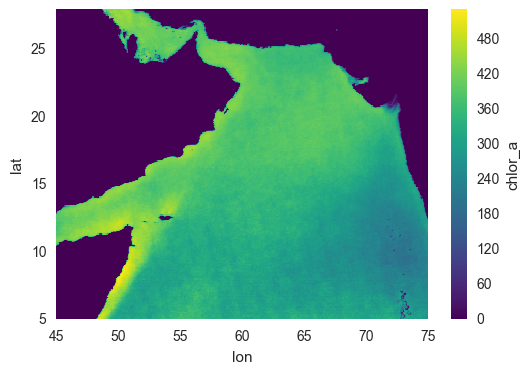

In [17]:
(ds_8day.chlor_a>0).sum(dim='time').plot()

/Users/vyan2000/local/miniconda3/envs/condapython3/lib/python3.5/site-packages/xarray/core/variable.py:1046: RuntimeWarning: invalid value encountered in greater
  if not reflexive


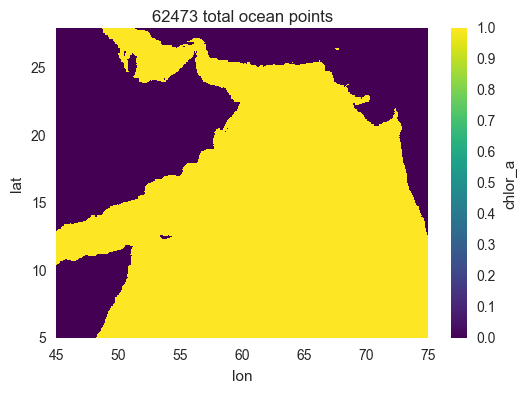

In [18]:
#  find a mask for the land
ocean_mask = (ds_8day.chlor_a>0).sum(dim='time')>0
#ocean_mask = (ds_daily.chlor_a>0).sum(dim='time')>0
num_ocean_points = ocean_mask.sum().values  # compute the total nonzeros regions(data point)
ocean_mask.plot()
plt.title('%g total ocean points' % num_ocean_points)

In [19]:
#ds_8day

In [20]:
#ds_daily

/Users/vyan2000/local/miniconda3/envs/condapython3/lib/python3.5/site-packages/matplotlib/colors.py:1022: RuntimeWarning: invalid value encountered in less_equal
  mask |= resdat <= 0


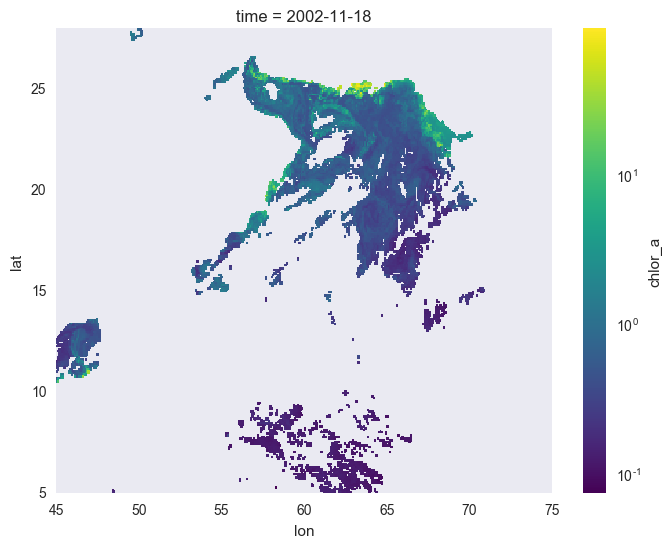

In [21]:
plt.figure(figsize=(8,6))
ds_daily.chlor_a.sel(time='2002-11-18',method='nearest').plot(norm=LogNorm())
#ds_daily.chlor_a.sel(time=target_date, method='nearest').plot(norm=LogNorm())

In [22]:
#list(ds_daily.groupby('time')) # take a look at what's inside

Now we count up the number of valid points in each snapshot and divide by the total number of ocean points.

In [23]:
'''
<xarray.Dataset>
Dimensions:        (eightbitcolor: 256, lat: 144, lon: 276, rgb: 3, time: 4748)
'''
ds_daily.groupby('time').count() # information from original data

<xarray.Dataset>
Dimensions:  (time: 5295)
Coordinates:
  * time     (time) datetime64[ns] 2002-07-04 2002-07-05 2002-07-06 ...
Data variables:
    palette  (time) int64 768 768 768 768 768 768 768 768 768 768 768 768 ...
    chlor_a  (time) int64 658 1170 1532 2798 2632 1100 1321 636 2711 1163 ...

In [24]:
ds_daily.chlor_a.groupby('time').count()/float(num_ocean_points)

<xarray.DataArray 'chlor_a' (time: 5295)>
array([ 0.01053255,  0.01872809,  0.02452259, ...,  0.        ,
        0.        ,  0.        ])
Coordinates:
  * time     (time) datetime64[ns] 2002-07-04 2002-07-05 2002-07-06 ...

In [25]:
count_8day,count_daily = [ds.chlor_a.groupby('time').count()/float(num_ocean_points)
                            for ds in (ds_8day,ds_daily)]

In [26]:
#count_8day = ds_8day.chl_ocx.groupby('time').count()/float(num_ocean_points)
#coundt_daily = ds_daily.chl_ocx.groupby('time').count()/float(num_ocean_points)

#count_8day, coundt_daily = [ds.chl_ocx.groupby('time').count()/float(num_ocean_points)
#                            for ds in ds_8day, ds_daily] # not work in python 3


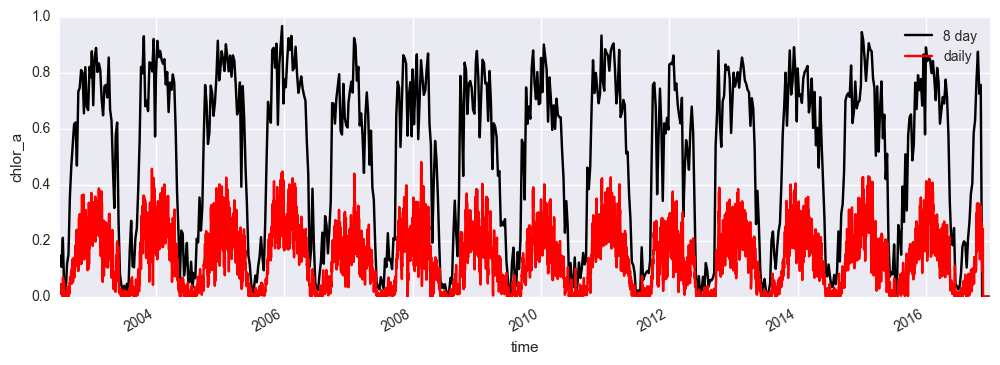

In [32]:
plt.figure(figsize=(12,4))
count_8day.plot(color='k')
count_daily.plot(color='r')

plt.legend(['8 day','daily'])

## Seasonal Climatology

In [28]:
count_8day_clim, coundt_daily_clim = [count.groupby('time.month').mean()  # monthly data
                                      for count in (count_8day, count_daily)]

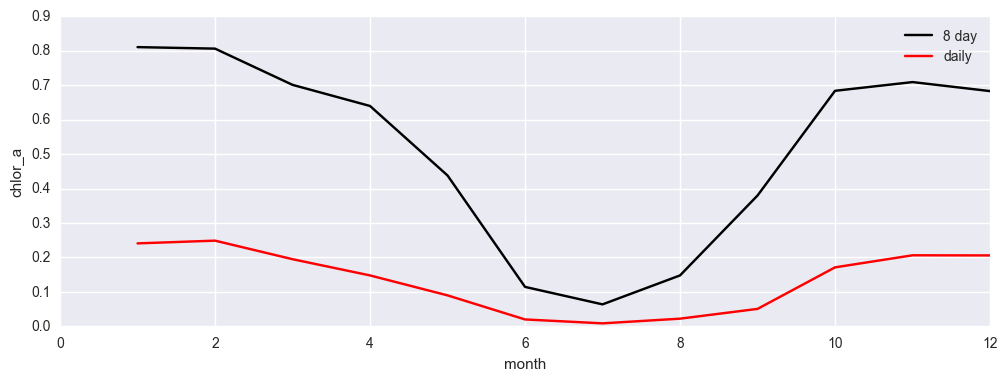

In [29]:
# mean value of the monthly data on the count of nonzeros
plt.figure(figsize=(12,4))
count_8day_clim.plot(color='k')
coundt_daily_clim.plot(color='r')
plt.legend(['8 day', 'daily'])

From the above figure, we see that data coverage is highest in the winter (especially Feburary) and lowest in summer.

## Maps of individual days

Let's grab some data from Febrauary and plot it.

/Users/vyan2000/local/miniconda3/envs/condapython3/lib/python3.5/site-packages/matplotlib/colors.py:1022: RuntimeWarning: invalid value encountered in less_equal
  mask |= resdat <= 0


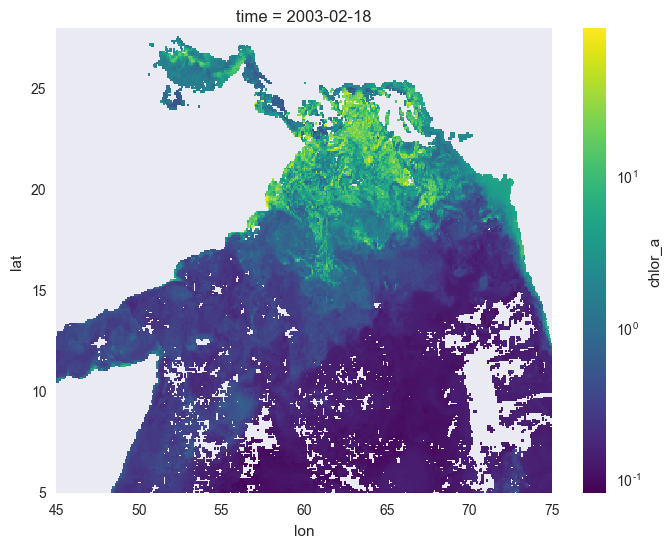

In [30]:
target_date = '2003-02-15'
plt.figure(figsize=(8,6))
ds_8day.chlor_a.sel(time=target_date, method='nearest').plot(norm=LogNorm())

/Users/vyan2000/local/miniconda3/envs/condapython3/lib/python3.5/site-packages/matplotlib/colors.py:1022: RuntimeWarning: invalid value encountered in less_equal
  mask |= resdat <= 0


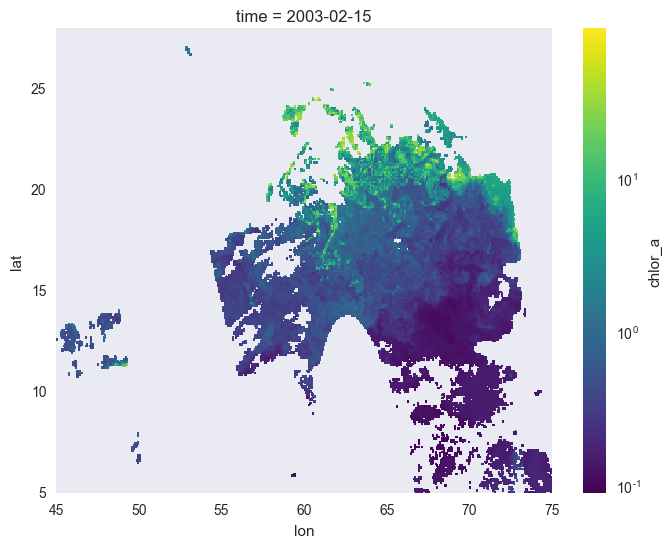

In [31]:
plt.figure(figsize=(8,6))
ds_daily.chlor_a.sel(time=target_date, method='nearest').plot(norm=LogNorm())

In [33]:
ds_daily.chlor_a[0].sel_points(lon=[65, 70], lat=[16, 18], method='nearest')   # the time is selected!
#ds_daily.chl_ocx[0].sel_points(time= times, lon=lons, lat=times, method='nearest')

<xarray.DataArray 'chlor_a' (points: 2)>
array([ nan,  nan])
Coordinates:
    time     datetime64[ns] 2002-07-04
    lon      (points) float64 65.04 70.04
    lat      (points) float64 16.04 18.04
  * points   (points) int64 0 1

In [34]:
df = pd.DataFrame([[1.4, np.nan], [7.1, -4.5], [np.nan, np.nan], [0.75, -1.3]], 
               index=['a', 'b', 'c', 'd'], columns=['one', 'two'])
df.mean(axis=1,skipna=None) # try skipna=False, skipna=True(seems to equiv to skipna=None)

a    1.400
b    1.300
c      NaN
d   -0.275
dtype: float64

In [ ]:
# Monthly resample starting from here


In [37]:
freq_resample = 'M'   # resampling using month end
print("resampling frequency is ", freq_resample)
ds_resample = ds_daily.resample(freq_resample, dim='time')  # see the above for doc, test case, & default behavior
ds_resample

resampling frequency is  M


<xarray.Dataset>
Dimensions:        (eightbitcolor: 256, lat: 276, lon: 360, rgb: 3, time: 174)
Coordinates:
  * lat            (lat) float64 27.96 27.87 27.79 27.71 27.62 27.54 27.46 ...
  * lon            (lon) float64 45.04 45.13 45.21 45.29 45.38 45.46 45.54 ...
  * rgb            (rgb) int64 0 1 2
  * eightbitcolor  (eightbitcolor) int64 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 ...
  * time           (time) datetime64[ns] 2002-07-31 2002-08-31 2002-09-30 ...
Data variables:
    palette        (time, rgb, eightbitcolor) float64 -109.0 0.0 108.0 ...
    chlor_a        (time, lat, lon) float64 nan nan nan nan nan nan nan nan ...

In [ ]:

# plot each of them in a loop


# how to plot the values

In [60]:
# http://xarray.pydata.org/en/stable/time-series.html
# key: xarray 
'''
print(ds_resample['time.month'])
print(ds_resample['time.year'])
print(ds_resample['time.year']==2002)
'''

"\nprint(ds_resample['time.month'])\nprint(ds_resample['time.year'])\nprint(ds_resample['time.year']==2002)\n"

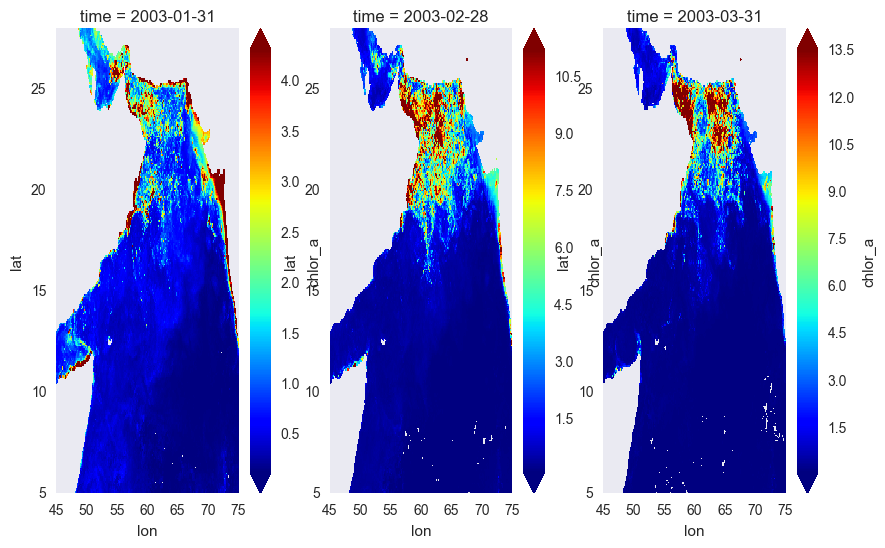

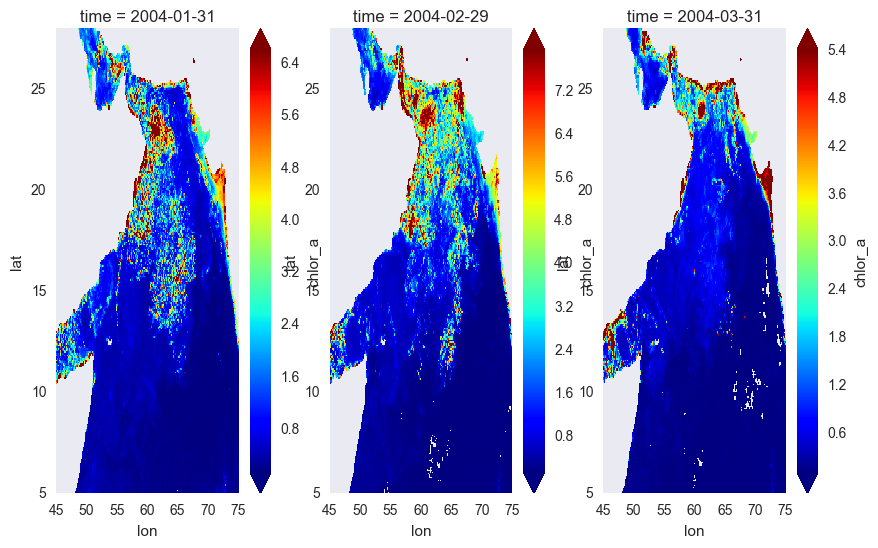

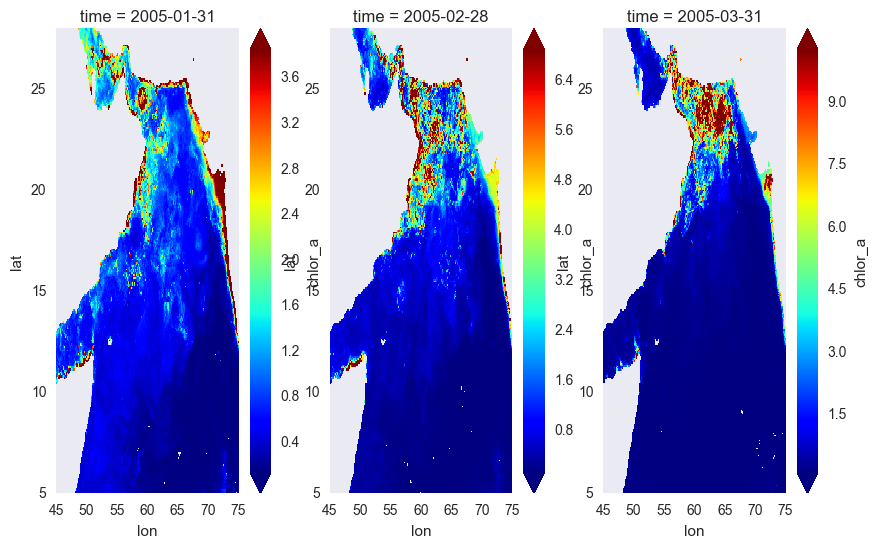

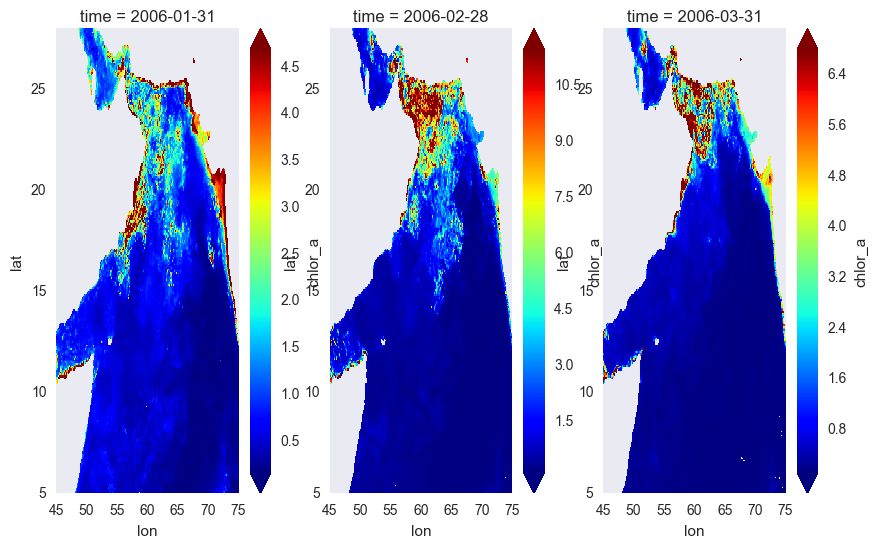

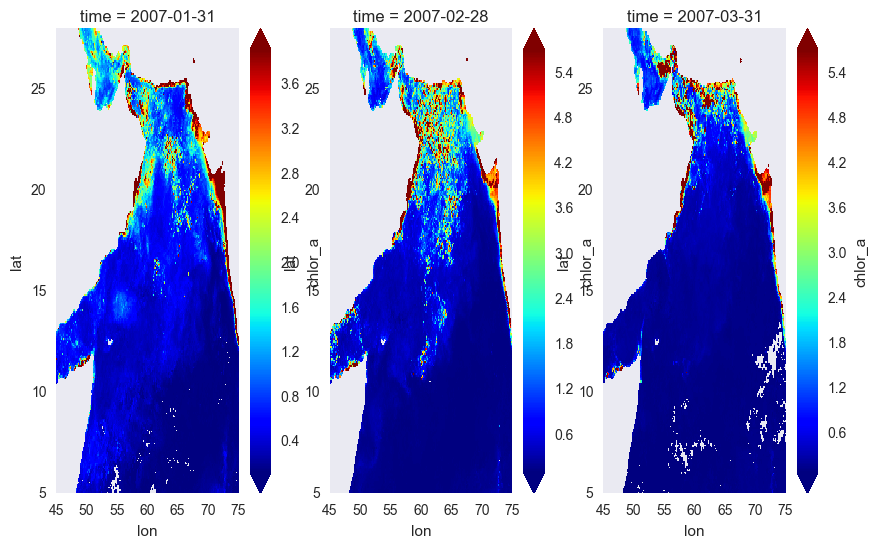

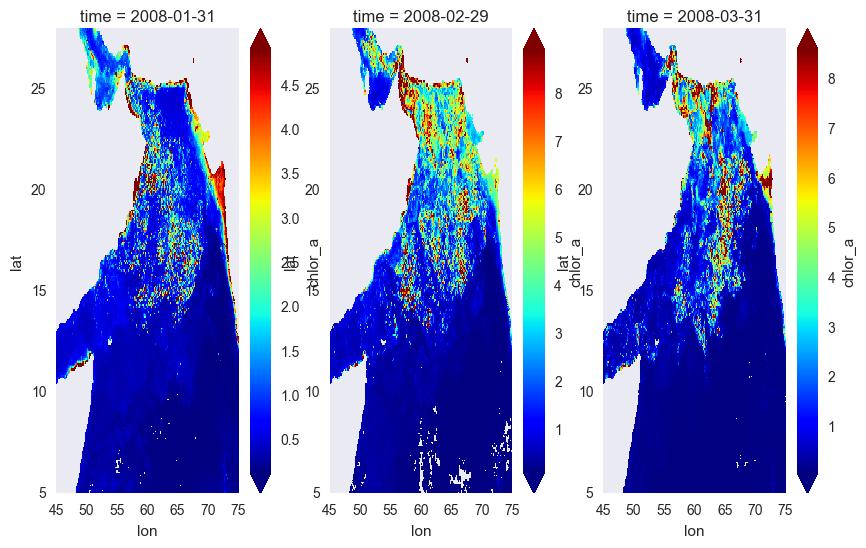

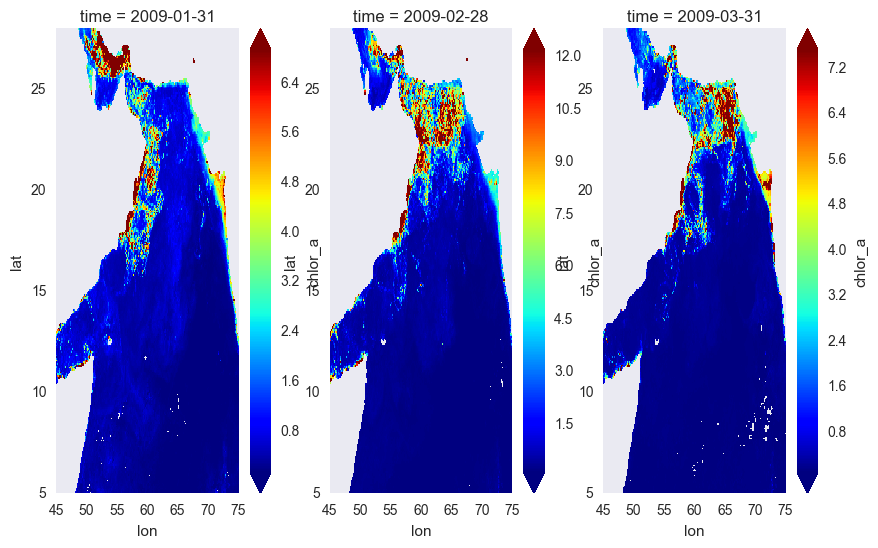

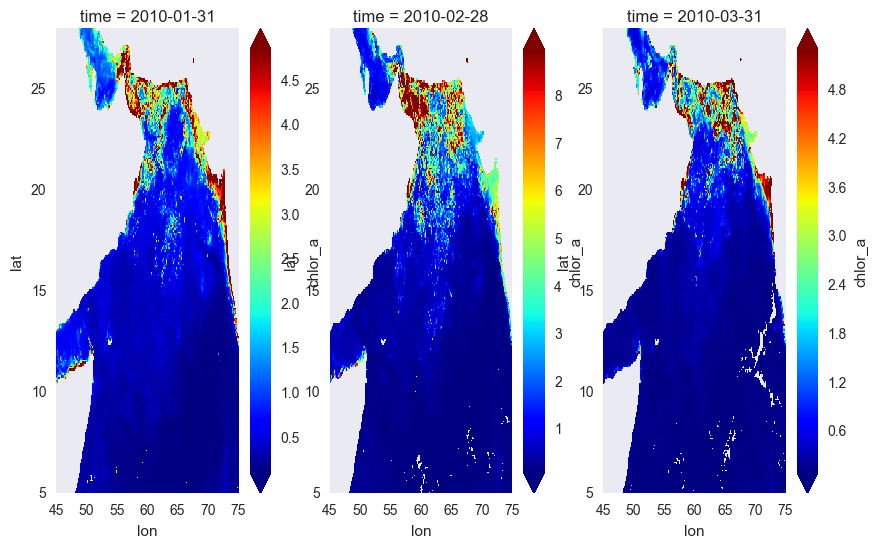

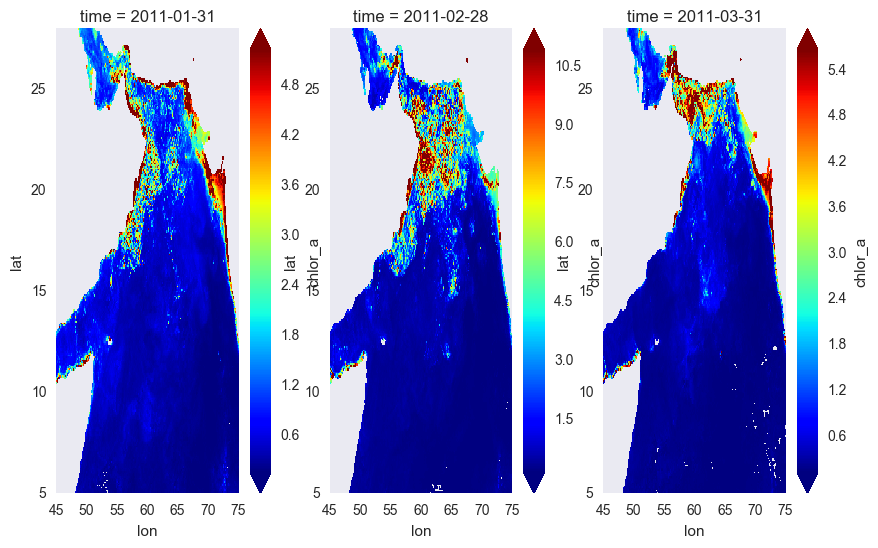

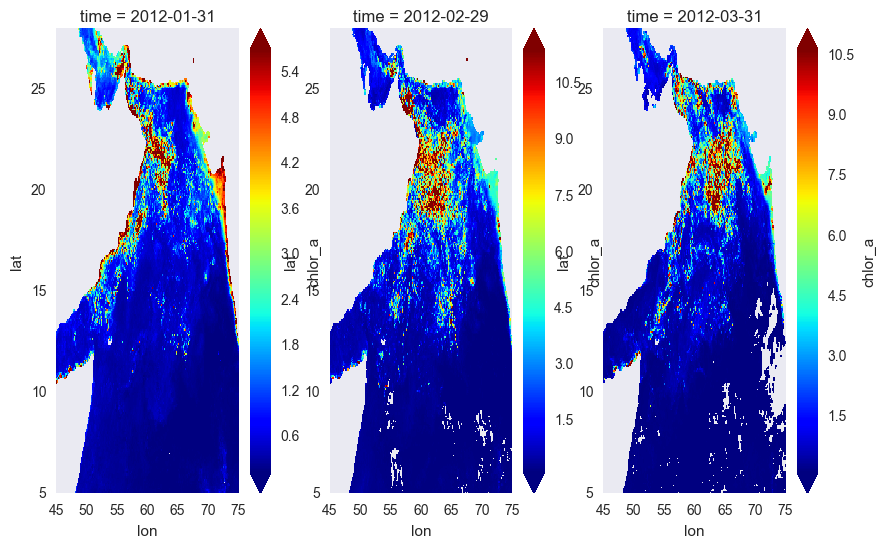

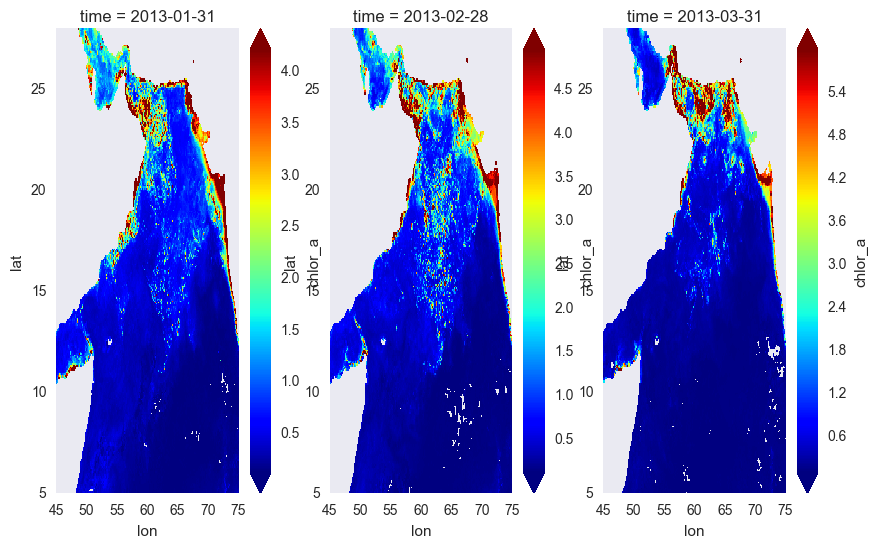

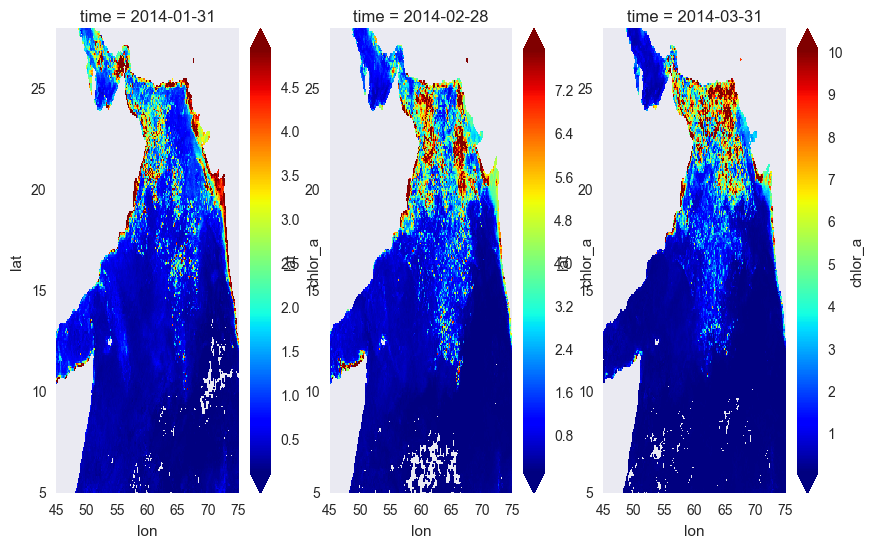

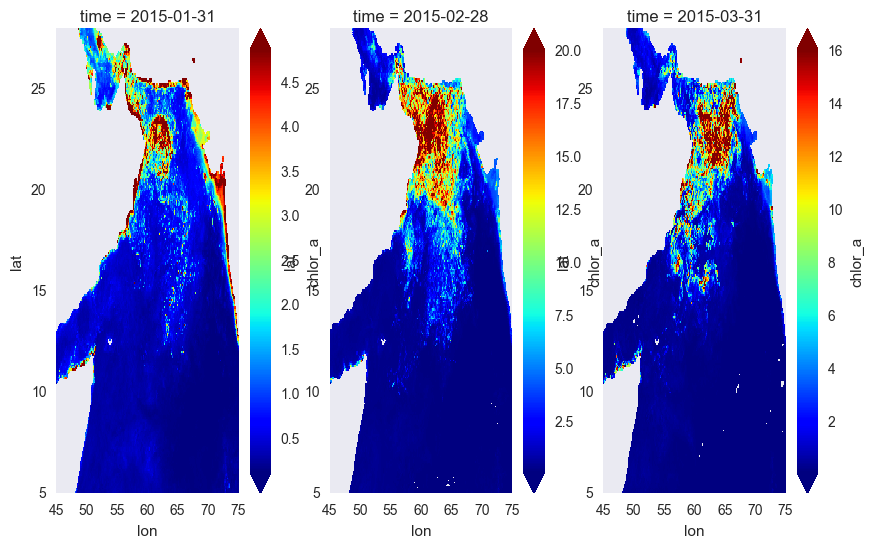

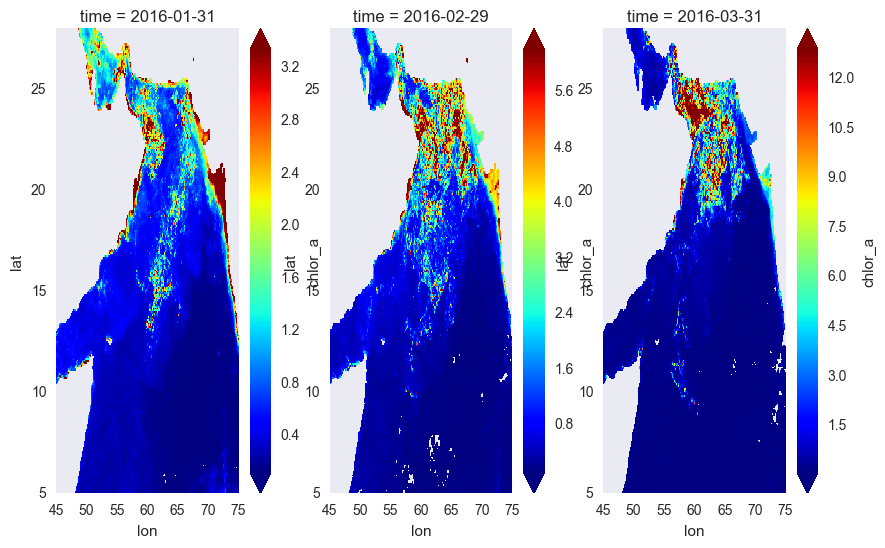

In [144]:
### Approach 1
### gather the data, and plot
### norm=LogNorm() removed
### use robust (outlier not considered)
### hard to remove cmap

for year in range(2003, 2017):
    fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(10,6))
    
    for month in range(1,4):
        plt.subplot(130+month)
        time_target = str(year) + "-0" + str(month)
        im = ds_resample.chlor_a.sel(time=time_target,  method='nearest').plot(robust=True, cmap="jet") 

    #fig.subplots_adjust(right=0.8)
    #cbar_ax = fig.add_axes([0.85, 0.15, 0.025, 0.7])
    #fig.colorbar(im, cax=cbar_ax, )

    plt.show()
    plt.close()

[numpy.datetime64('2016-02'), numpy.datetime64('2016-03'), numpy.datetime64('2016-04')]


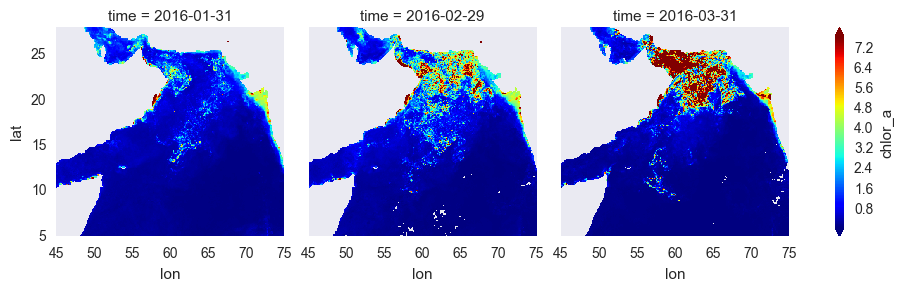

In [149]:
##### some tests ####
time_target = [np.datetime64(str(year) + '-02'), np.datetime64(str(year) + '-03'), np.datetime64(str(year) + '-04')]
print(time_target)
ds_resample.chlor_a.sel(time= list(time_target),  method='nearest').plot(x='lon', y='lat', col='time',  cmap="jet",  robust=True, col_wrap=3)

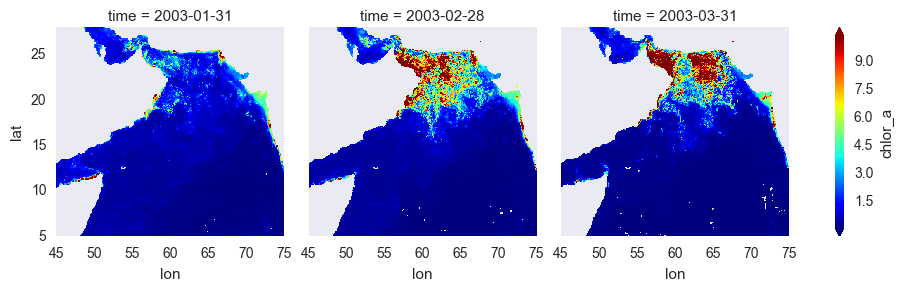

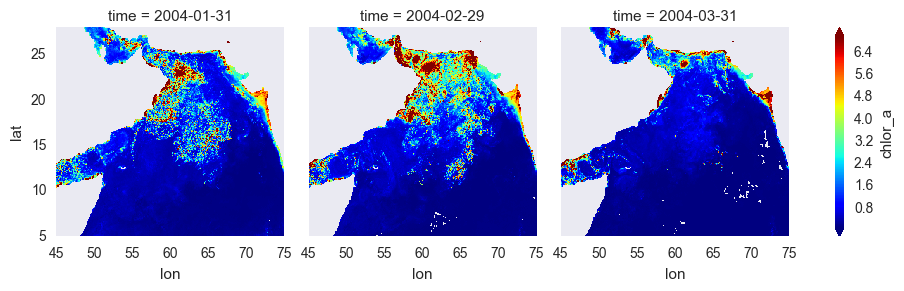

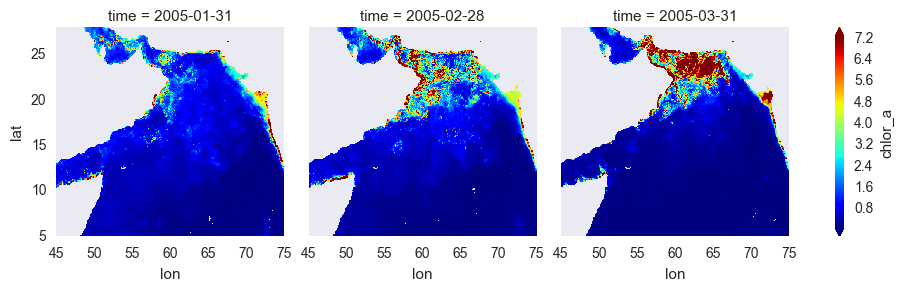

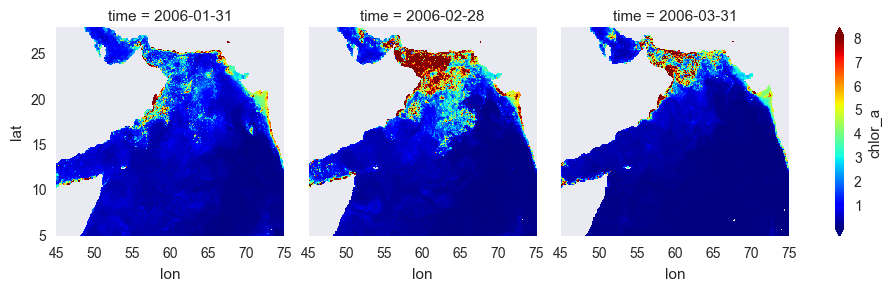

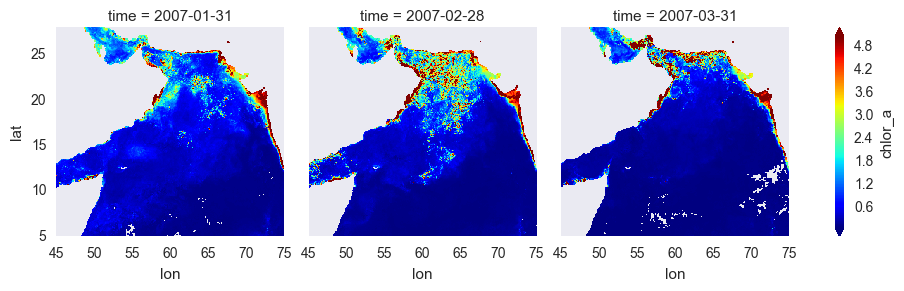

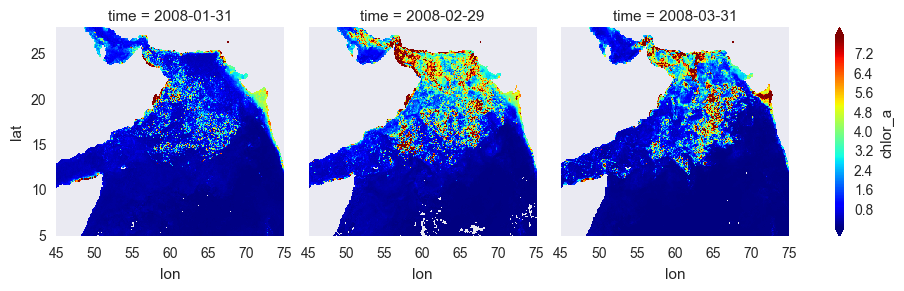

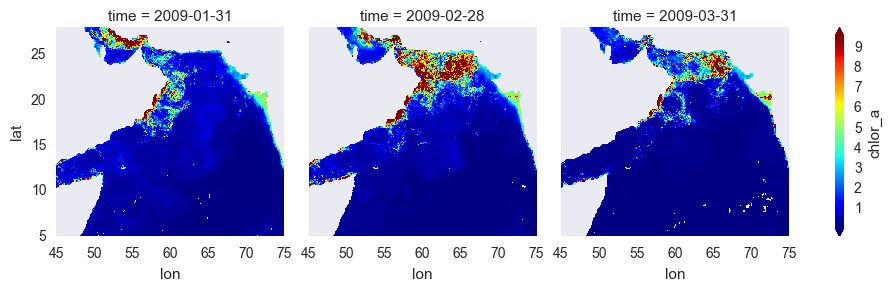

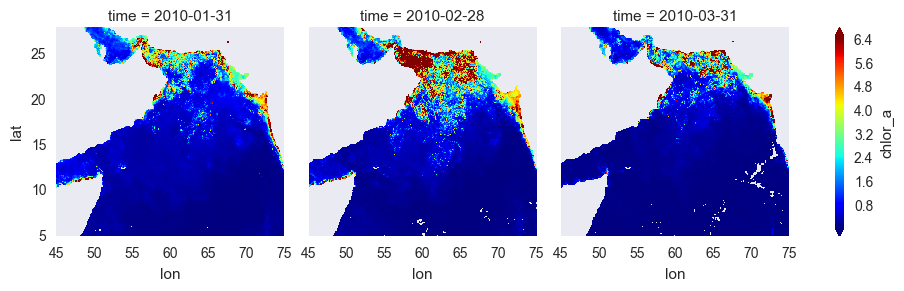

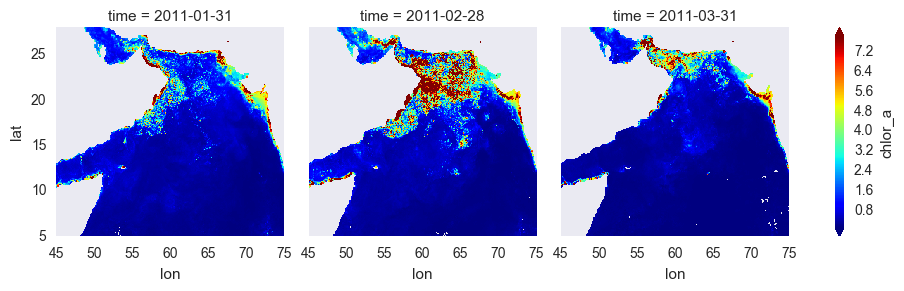

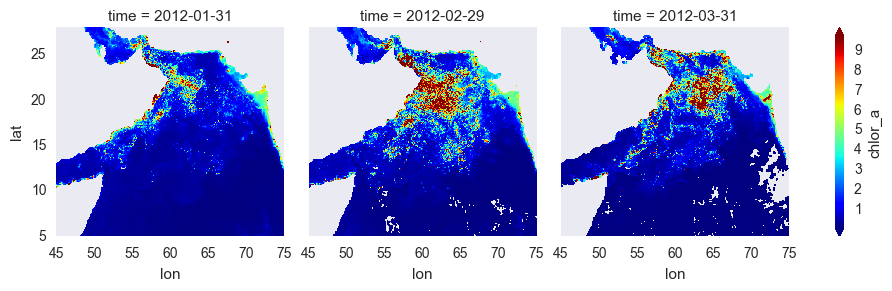

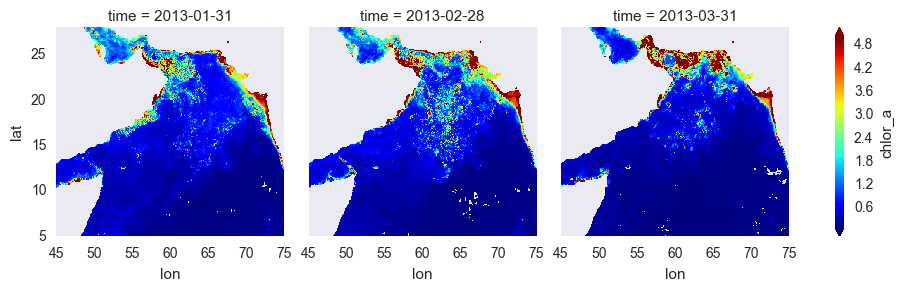

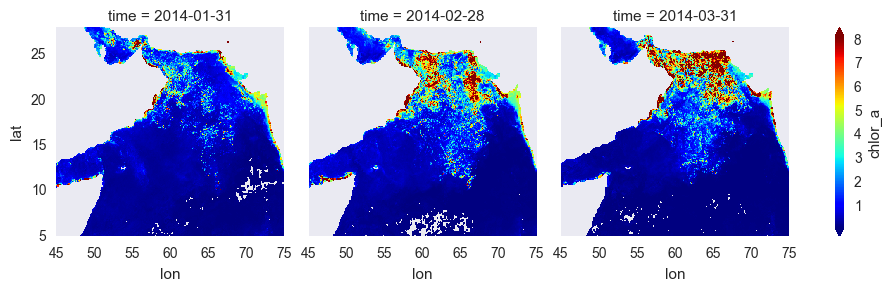

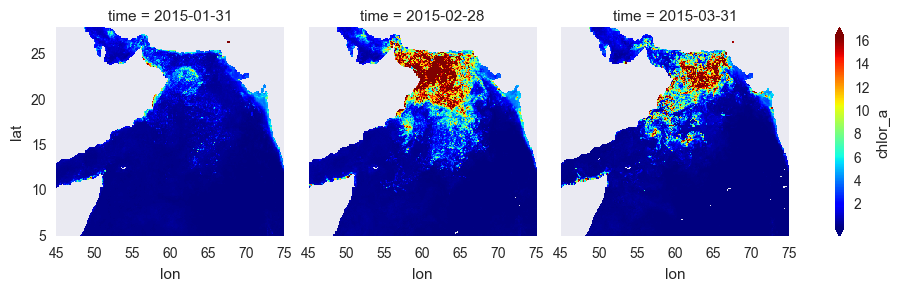

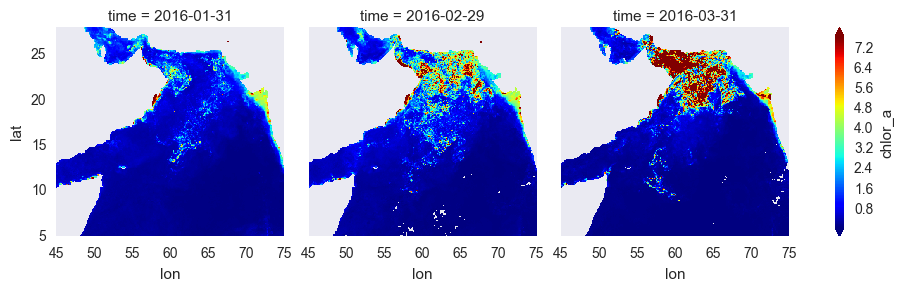

In [148]:
### Approach 2
### use xarray: http://xarray.pydata.org/en/stable/plotting.html
### gather the data, and plot
### norm=LogNorm() removed
### use robust (outlier not considered)

for year in range(2003, 2017):
    time_target = [np.datetime64(str(year) + '-02'), np.datetime64(str(year) + '-03'), np.datetime64(str(year) + '-04')]
    ds_resample.chlor_a.sel(time= list(time_target),  method='nearest').plot(x='lon', y='lat', col='time',  cmap="jet",  robust=True, col_wrap=3)

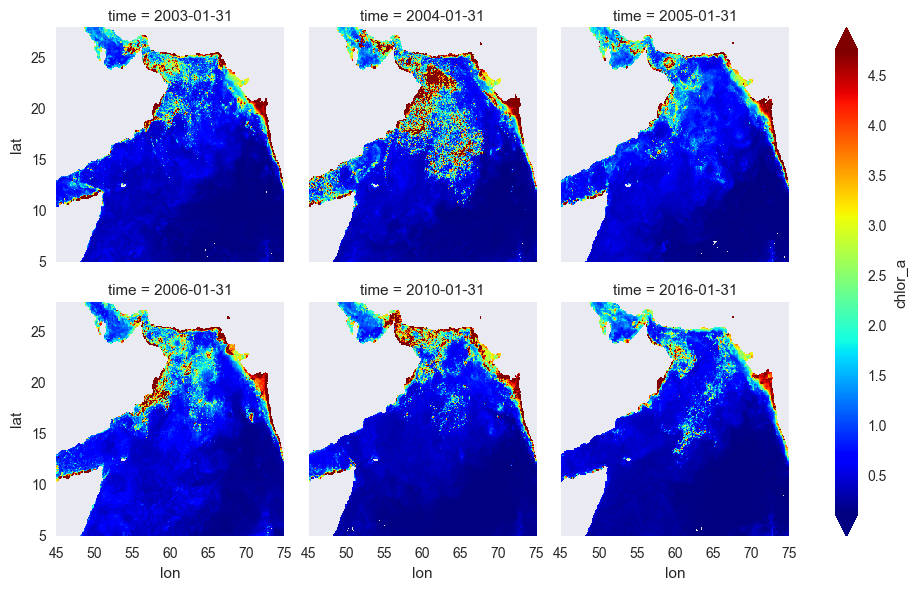

In [157]:
### Approach 3
### use xarray: http://xarray.pydata.org/en/stable/plotting.html
### focus on a particular month, and plot
### norm=LogNorm() removed
### use robust (outlier not considered)


time_target2 = [np.datetime64(str(year) + '-02') for year in np.array([2003, 2004,2005,2006,2010,2016])]
#time_target3 = [np.datetime64(str(year) + '-03') for year in range(2003, 2017)]
#time_target4 = [np.datetime64(str(year) + '-04') for year in range(2003, 2017)]

ds_resample.chlor_a.sel(time= list(time_target2),  method='nearest').plot(x='lon', y='lat', col='time',  cmap="jet",  robust=True, col_wrap=3)